# Ensemble Learning for Song Identification from Humming and Whistling


# 1 Author

- **Student Name**: Philipp Schmidt


---

# 2 Problem Formulation

This project addresses automated song recognition from human vocal interpretations.
The task is formulated as a supervised multi-class classification problem: given a 10-second audio recording of humming or whistling, identify which of eight songs is being performed.

The classification challenge arises from three key factors:

- human vocal interpretations introduce pitch, tempo, and accuracy variations across performers,
- the absence of lyrics and instrumentation removes conventional audio features,
- recordings exhibit environmental noise, variable quality, and inconsistent loudness.


---

# 3 Methodology

The approach employs a supervised learning framework with three dataset configurations and a stratified four-way split.

We create separate datasets for

- combined humming and whistling samples,
- humming-only samples,
- whistling-only samples.

Each dataset is partitioned into training (70%), test (21%), and validation (9%) sets with stratification ensuring balanced class representation.

The methodology comprises three optimisation stages:

**Stage 1: Preprocessing Optimisation**. Grid search over preprocessing hyperparameters using 5% of training data balances computational efficiency with representative sampling. Parameters controlling noise reduction, volume normalisation, silence trimming, and sampling rate are optimised using a lightweight SVM classifier, with validation accuracy as the metric.

**Stage 2: SVM Hyperparameter Optimisation**. Independent grid searches for combined, humming, and whistling models over PCA dimensionality $n \in \{20, 30, 50, 70, 100\}$, kernel type $k \in \{\mathrm{RBF}, \mathrm{polynomial}, \mathrm{sigmoid}\}$, regularisation parameter $C \in \{10^{-3}, \ldots, 10^{2}\}$, and kernel coefficient $\gamma \in \{\mathrm{scale}, \mathrm{auto}, 10^{-3}, 10^{-2}, 10^{-1}\}$. Validation accuracy guides each search.

**Stage 3: Ensemble Learning**. A weighted ensemble meta-classifier learns optimal combination of predictions from all three base models using Logistic Regression. Probability predictions from the combined, humming, and whistling models serve as meta-features (24 dimensions: 8 classes $\times$ 3 models), enabling the ensemble to exploit complementary model strengths.

Performance is quantified using classification accuracy, per-class precision/recall/F1-scores, confusion matrices, and ensemble weight analysis.


---

# 4 Implemented ML Prediction Pipelines

The prediction pipeline transforms raw audio waveforms (one-dimensional NumPy arrays with associated sampling rate) into song predictions through three sequential stages:

**Stage 1: Audio Preprocessing**. Raw waveforms undergo resampling to consistent sampling rate, silence trimming, background noise reduction, and loudness normalisation. Output remains a one-dimensional array with standardised properties.

**Stage 2: Feature Extraction**. Preprocessed signals are transformed into 250-dimensional feature vectors comprising Mel-Frequency Cepstral Coefficients (MFCCs), chroma features, spectral contrast, zero-crossing rate, and pitch contour descriptors.

**Stage 3: Classification**. Feature vectors are standardised, dimensionality-reduced via PCA, and classified using SVM with optimised hyperparameters, yielding discrete song labels.


---

## 4.1 Transformation Stage

The transformation stage converts variable-length, high-dimensional raw audio into fixed-length feature vectors encoding musically meaningful information.

#### Preprocessing Pipeline

Four transformations ensure consistency:

**Sampling Rate Normalisation**: Resampling to common rate (optimised to 16 kHz or 22 kHz) using `librosa` ensures temporal-spectral consistency, as different sampling rates produce different frequency representations.

**Silence Trimming**: Energy-based threshold (optimised between 20–30 dB below peak) removes leading/trailing quiet segments.

**Noise Reduction**: The `noisereduce` library estimates and subtracts quasi-stationary noise whilst preserving dynamic vocal content. Reduction strength optimised between 0.1 and 0.5 balances noise suppression with signal preservation.

**Volume Normalisation**: Scaling to target RMS level of 0.1 ensures consistent loudness, preventing the classifier from learning volume-based patterns.

#### Feature Extraction

Feature extraction using `librosa` computes 250 features in two categories:

**Acoustic Features (122 dimensions)**: Harmonic-percussive source separation (HPSS) isolates the harmonic component for tonal feature computation, improving robustness to breathing noise. Features comprise:

- 20 MFCCs + temporal derivatives (80 features): spectral envelope representation,
- 12 chroma features + statistics (24 features): pitch class energy distribution,
- Spectral contrast across frequency bands (14 features): texture characterisation,
- Spectral rolloff (2 features): brightness indicator,
- Zero-crossing rate (2 features): signal noisiness measure.

**Pitch Contour Features (128 dimensions)**: The YIN algorithm tracks fundamental frequency over time, converted to semitone scale, centred around median pitch, and resampled to 64 fixed time steps. First differences capture melodic intervals. This produces 128 features encoding melodic trajectory independently of absolute pitch or key.


---

## 4.2 Model Stage

Support Vector Machine (SVM) classifiers within `scikit-learn` Pipelines provide the core prediction models.
Three separate SVMs are trained (combined, humming-only, whistling-only), each comprising feature standardisation, dimensionality reduction, and the SVM classifier.

#### Feature Standardisation

`StandardScaler` transforms features to zero mean and unit variance.
This is essential for SVMs as the algorithm is scale-sensitive.
Scaler parameters are fitted exclusively on training data and applied consistently to validation and test sets, preventing data leakage.

#### Dimensionality Reduction via PCA

Principal Component Analysis (PCA) projects the 250-dimensional space onto a lower-dimensional subspace retaining maximal variance.
This

- mitigates the curse of dimensionality when features approach sample count,
- removes feature redundancy and correlation, and
- reduces computational cost.
  The number of components $n \in \{20, 30, 50, 70, 100\}$ is optimised via grid search.

#### Support Vector Machine Classifier

SVMs construct optimal decision boundaries by maximising the margin between support vectors.
Selection rationale:

- effectiveness in high-dimensional spaces,
- memory efficiency (storing only support vectors), and
- the kernel trick enables nonlinear decision boundaries via implicit higher-dimensional mappings.

Three hyperparameters are optimised via validation-based grid search:

**Kernel Function**: Determines decision boundary shape. Evaluated kernels: RBF, polynomial, sigmoid.

**Regularisation Parameter $C$**: Controls the trade-off between maximising margin and minimising training errors. Low $C$ prefers wider margins (potential underfitting); high $C$ prioritises correct training classification (potential overfitting). Search range: $C \in \{10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 10^{2}\}$.

**Kernel Coefficient $\gamma$**: Defines influence radius of training samples. Low $\gamma$ produces broad, smooth boundaries; high $\gamma$ creates tight, complex boundaries. Evaluated values: $\gamma \in \{\mathrm{scale}, \mathrm{auto}, 10^{-3}, 10^{-2}, 10^{-1}\}$.


---

## 4.3 Ensemble Stage

The ensemble stage combines predictions from three specialised SVM models via meta-learning using Logistic Regression as a weighted meta-classifier.

The ensemble architecture uses probability predictions from all three base models as input features.
Each base model outputs 8 class probabilities, creating 24 meta-features $(8 \text{ classes} \times 3 \text{ models})$.
The Logistic Regression meta-classifier (LBFGS solver, 1000 iterations maximum, random state 0) processes these probability vectors to produce final predictions with confidence scores.

**Training Process**:

1. Train each SVM independently with optimised hyperparameters on respective datasets
2. Generate probability predictions for the combined training set, creating 24-dimensional feature vectors
3. Train Logistic Regression meta-classifier on these probability predictions with true song labels
4. Validate using probability predictions on the validation set.

**Benefits**:

- Model specialisation
  - humming and whistling models learn interpretation-specific patterns whilst the combined model captures general characteristics
- Adaptive weighting
  - the meta-classifier learns which base model to trust for different songs rather than using fixed weights
- Robustness
  - combining multiple perspectives potentially corrects individual model errors
- Low-dimensional meta-learning
  - using probability predictions rather than raw features creates a 24-dimensional problem, reducing overfitting risk despite the moderate dataset size (800 samples)

The trained ensemble coefficients reveal each base model's contribution to final predictions.


---

# 5 Dataset

The [MLEnd Hums and Whistles II](https://github.com/thekmannn/MLEndHW_Sample) dataset comprises 800 audio recordings (WAV format) of eight songs performed by multiple participants through humming and whistling.

#### Dataset Structure

File names follow the convention `participantID_interpretationType_interpretationNumber_songName.wav`.
The eight songs are: "Feeling", "Friend", "Happy", "Married", "Necessities", "New York", "Remember Me", and "Try Everything".
Each song has multiple performances by different participants using both humming and whistling.

Filenames are parsed to extract metadata (participant identity, interpretation type, interpretation attempt number, song label) encapsulated in an `AudioSample` class that validates naming convention and provides structured property access.

Limitations include variability in participants' musical ability, potential memorability differences between songs, and limited participant diversity.

#### Dataset Splitting

Data is partitioned into training (70%), test (21%), and validation (9%) sets using stratified random sampling.
Stratification ensures proportional song representation across all sets, preventing scenarios where particular songs might be absent from validation or test sets.


---

# 6 Experiments and Results

#### Experimental Pipeline

The experimental workflow comprises six stages:

1. Data loading and stratified splitting for all three dataset configurations (combined, humming, whistling)
2. Preprocessing optimisation via grid search on 5% training subset
3. Feature extraction producing 250-dimensional vectors
4. Independent SVM hyperparameter optimisation for each dataset over PCA components, kernel type, $C$, and $\gamma$
5. Base model training and evaluation on train/validation/test sets
6. Ensemble meta-classifier training and performance comparison

#### Performance Overview

The multi-model approach yields strong performance, as base SVM models (combined, humming, whistling) achieve training accuracy of approximately 90–100% and test accuracy of 55–70%.
The weighted ensemble typically exceeds the best individual base model through learned combination of prediction.

#### Evaluation Metrics

For each model we compute:

- Accuracy on train/validation/test sets
- Per-class precision/recall/F1-scores revealing song-specific performance
- Confusion matrices visualising prediction patterns and frequently confused songs
- Weight analysis (ensemble only) showing average contribution of each base model

#### Key Findings

Classification reports reveal per-class performance variations.
Songs with distinctive melodic contours achieve higher precision/recall, whilst songs with similar melodic structures exhibit systematic misclassification.
Confusion matrices visualise these patterns.

The training-test accuracy gap indicates some overfitting, expected given moderate dataset size (800 samples) and high model complexity (250 features, nonlinear kernels).
However, test accuracy substantially exceeds random chance, demonstrating that models learn meaningful melodic and acoustic patterns rather than memorising noise.

Ensemble weight analysis reveals how the meta-classifier distributes trust across base models, providing insights into when specialised models (humming/whistling) versus the general model (combined) are most reliable.


---

#### Download Requirements

First, ensure that you have downloaded all the necessary requirements from the
`requirements.txt` file.


In [ ]:
import os
import subprocess
import sys

if os.path.exists('requirements.txt'):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", "requirements.txt"])
else:
    print("requirements.txt not found. Installing packages manually...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ipywidgets==8.1.5", "librosa==0.11.0", "noisereduce==3.0.3", "numpy==2.3.5", "pandas==2.3.3", "seaborn==0.13.2", "tqdm==4.67.1"])

# list installed pip packages after installation
print("Installed dependencies:\n")
print(subprocess.check_output([sys.executable, "-m", "pip", "freeze"]).decode())


Installed dependencies:

appnope==0.1.4
asttokens==3.0.1
audioop-lts==0.2.2
audioread==3.1.0
certifi==2025.11.12
cffi==2.0.0
charset-normalizer==3.4.4
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.17
decorator==5.2.1
executing==2.2.1
fonttools==4.60.1
idna==3.11
ipykernel==7.1.0
ipython==9.7.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.5
jedi==0.19.2
joblib==1.5.2
jupyter_client==8.6.3
jupyter_core==5.9.1
jupyterlab_widgets==3.0.16
kiwisolver==1.4.9
lazy_loader==0.4
librosa==0.11.0
llvmlite==0.45.1
matplotlib==3.10.7
matplotlib-inline==0.2.1
msgpack==1.1.2
nest-asyncio==1.6.0
noisereduce==3.0.3
numba==0.62.1
numpy==2.3.5
packaging==25.0
pandas==2.3.3
parso==0.8.5
pexpect==4.9.0
pillow==12.0.0
platformdirs==4.5.0
pooch==1.8.2
prompt_toolkit==3.0.52
psutil==7.1.3
ptyprocess==0.7.0
pure_eval==0.2.3
pyaml==25.7.0
pycparser==2.23
Pygments==2.19.2
pyparsing==3.2.5
python-dateutil==2.9.0.post0
pytz==2025.2
PyYAML==6.0.3
pyzmq==27.1.0
requests==2.32.5
scikit-learn==1.7.2
scikit-

In [2]:
# Standard library
import glob
import re
import urllib.request
import zipfile
from enum import Enum
from typing import Optional


# Third-party
import librosa
import matplotlib.pyplot as plt
import noisereduce as nr
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm


---

#### Hyperparameters

Initialise hyperparameters dictionary for tracking all model/preprocessing parameters.


In [3]:
HYPERPARAMETERS = {}


---

#### Download Dataset

After downloading the dataset, we store it on the machine and extract the files.


In [4]:
def download_url(url: str, save_path: str, block_size: int = 8192, show_progress: bool = True, timeout: Optional[int] = 30) -> str:
    '''
    Download a file from a URL to a local path with a tqdm progress bar.

    Parameters
    ----------
    url : str
        The URL of the file to download.
    save_path : str
        Local filesystem path where the downloaded file will be written.
    block_size : int, optional
        Number of bytes to read per iteration (download chunk size). Default is 8192.
    show_progress : bool, optional
        If True, display a tqdm progress bar. Set to False to disable. Default is True.
    timeout : int or None, optional
        Timeout in seconds for the underlying request. Use None for no timeout. Default is 30.

    Returns
    -------
    str
        The same save_path passed in (useful for chaining).

    Raises
    ------
    URLError, HTTPError
        Propagates errors from urllib if the download fails.
    '''
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req, timeout=timeout) as dl_file:
        raw_size = dl_file.getheader('Content-Length')
        total_size = int(raw_size) if raw_size and raw_size.isdigit() else 0
        total_arg = total_size if total_size > 0 else None

        with open(save_path, 'wb') as out_file, tqdm(total=total_arg, unit='B', unit_scale=True, desc="Downloading", disable=not show_progress) as pbar:
            while True:
                data = dl_file.read(block_size)
                if not data:
                    break
                out_file.write(data)
                pbar.update(len(data))

    return save_path


In [5]:
# Download the 800 sample size dataset
file_name = "MLEndHWII_Sample_800.zip"

url = f"https://github.com/thekmannn/MLEndHW_Sample/raw/main/{file_name}"

base_path = os.path.join('.', 'dataset')
print("=" * 60)
if not os.path.exists(base_path):
    os.makedirs(base_path, exist_ok=True)
    print(f"Created directory: {base_path}")
else:
    print(f"Directory exists: {base_path}")
print("=" * 60)
save_path_relative = os.path.join(base_path, file_name)

# If the file already exists and is non-empty skip re-downloading
if os.path.exists(save_path_relative) and os.path.getsize(save_path_relative) > 0:
    print(f"File already exists, skipping download: {save_path_relative}")
else:
    print(f"Saving to: {save_path_relative}")
    
    # Download the url
    download_url(url, save_path=save_path_relative)


Directory exists: ./dataset
File already exists, skipping download: ./dataset/MLEndHWII_Sample_800.zip


In [6]:
# Unzip the data
zip_path = save_path_relative
directory_to_extract_to = os.path.join(base_path, 'samples')
os.makedirs(directory_to_extract_to, exist_ok=True)

print("=" * 60)
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
    print(f"Extracted {zip_path} -> {directory_to_extract_to}")
except zipfile.BadZipFile:
    print(f"Bad zip file: {zip_path}")
except Exception as e:
    print("Extraction failed:", e)
    
# Store the samples in variable
# Dataset only consists of .wav files
# First, check what's in the directory
print("=" * 60)
print(f"Looking for files in: {directory_to_extract_to}")
print(f"Directory contents: {os.listdir(directory_to_extract_to) if os.path.exists(directory_to_extract_to) else 'Directory does not exist'}")

# The extracted folder might have a subfolder, so let's search recursively
samples_path = os.path.join(directory_to_extract_to, '**', '*.wav')
files = glob.glob(samples_path, recursive=True)

print("=" * 60)
print(f"Found {len(files)} .wav files")
print("=" * 60)


Extracted ./dataset/MLEndHWII_Sample_800.zip -> ./dataset/samples
Looking for files in: ./dataset/samples
Directory contents: ['MLEndHWII_sample_800', '.DS_Store', 'MLEndHWII_sample_400']
Found 1200 .wav files


---

#### Create Sample Definition

We create a class which holds the entities of a sample with the appropriate methods.


In [7]:
class AudioSample:
    '''
    Represents an audio sample from the MLEnd Hums and Whistles II dataset.
    
    Parses sample file names to extract metadata including participant ID,
    interpretation type (hum/whistle), interpretation number, and song name.
    
    Expected file name format: participantId_interpretationType_interpretationNumber_song[.wav]
    Example: S4_hum_1_Feeling.wav or S4_whistle_2_rememberMe.wav
    
    Attributes
    ----------
    path : str
        Full path to the audio sample file.
    file_name : str
        File name extracted from the path.
    participand_id : str
        Participant identifier (e.g., 's4').
    interpretation_type : InterpretationType
        Whether the sample is humming or whistling.
    interpretation_number : str
        The interpretation attempt number.
    song : Song
        The song being interpreted.
    '''
    
    class InterpretationType(Enum):
        '''
        Enumeration of valid interpretation types.
        '''
        HUM = "hum"
        WHISTLE = "whistle" 
        
    class Song(Enum):
        '''
        Enumeration of valid song names in the dataset.
        '''
        FEELING = "feeling"
        FRIEND = "friend"
        HAPPY = "happy"
        MARRIED = "married"
        NECESSITIES = "necessities"
        NEW_YORK = "new-york"
        REMEMBER_ME = "remember-me"
        TRY_EVERYTHING = "try-everything"
   
    def __init__(self, sample_path):
        '''
        Initialize an AudioSample by parsing the file path.
        
        Parameters
        ----------
        sample_path : str
            Path to the audio sample file.
            
        Raises
        ------
        ValueError
            If the file name doesn't match the expected format or contains invalid values.
        '''
        self.path = sample_path
        self.file_name = self._get_file_name_from_path(sample_path)
        self.participand_id = self._get_participant_id_from_sample_name(self.file_name)
        self.interpretation_type = self._get_interpretation_type_from_sample_name(self.file_name)
        self.interpretation_number = self._get_interpretation_number_from_sample_name(self.file_name)
        self.song = self._get_song_from_sample_name(self.file_name)
    
      
    def _get_file_name_from_path(self, sample_path: str) -> str:
        '''
        Extract and validate the file name from the full path.
        
        Parameters
        ----------
        sample_path : str
            Full path to the audio file.
            
        Returns
        -------
        str
            The validated file name.
            
        Raises
        ------
        ValueError
            If the file name doesn't match the expected pattern:
            participantId_interpretationType_interpretationNumber_song[.wav]
        '''
        # Get only the file name
        file_name = os.path.basename(sample_path)
        
        # Expected structure: participantId_interpretationType_interpretationNumber_song
        # e.g. S4_hum_1_Feeling or S4_whistle_2_rememberMe
        pattern = r'^[A-Za-z0-9]+_[A-Za-z]+_[0-9]+_[A-Za-z][A-Za-z0-9]*(?:\.[Ww][Aa][Vv])?$'
        if not re.match(pattern, file_name):
            raise ValueError(
                "Sample name does not follow expected structure "
                "'participantId_interpretationType_interpretationNumber_song[.wav]': "
                f"{file_name}"
            )
        return file_name
    
    @staticmethod
    def _strip_wav_extension(sample_name: str) -> str:
        '''
        Remove the .wav extension from a file name (case-insensitive).
        
        Parameters
        ----------
        sample_name : str
            File name potentially ending with .wav, .WAV, or mixed case.
            
        Returns
        -------
        str
            File name without the .wav extension.
        '''
        return re.sub(r'\.[Ww][Aa][Vv]$', '', sample_name)
    
    def _get_participant_id_from_sample_name(self, sample_name: str) -> str:
        '''
        Extract the participant ID from the sample file name.
        
        Parameters
        ----------
        sample_name : str
            The audio sample file name.
            
        Returns
        -------
        str
            Participant ID in lowercase (e.g., 's4').
        '''
        parts = self._strip_wav_extension(sample_name).split('_')
        return parts[0].lower()
        
    def _get_interpretation_type_from_sample_name(self, sample_name: str) -> InterpretationType:
        '''
        Extract and validate the interpretation type from the sample file name.
        
        Parameters
        ----------
        sample_name : str
            The audio sample file name.
            
        Returns
        -------
        InterpretationType
            The interpretation type enum (HUM or WHISTLE).
            
        Raises
        ------
        ValueError
            If the interpretation type is not 'hum' or 'whistle'.
        '''
        parts = self._strip_wav_extension(sample_name).split('_')
        interpretation_type_str = parts[1].lower()
        try:
            return self.InterpretationType(interpretation_type_str)
        except ValueError:
            valid = [e.value for e in self.InterpretationType]
            raise ValueError(f"Invalid interpretation type '{parts[1]}'. Expected one of: {valid}")
        
        
        
    def _get_interpretation_number_from_sample_name(self, sample_name: str) -> str:
        '''
        Extract the interpretation number from the sample file name.
        
        Parameters
        ----------
        sample_name : str
            The audio sample file name.
            
        Returns
        -------
        str
            The interpretation attempt number in lowercase.
        '''
        parts = self._strip_wav_extension(sample_name).split('_')
        return parts[2].lower()
    
    def _get_song_from_sample_name(self, sample_name: str) -> Song:
        '''
        Extract and validate the song name from the sample file name.
        
        Converts CamelCase or camelCase song names to kebab-case before validation.
        Examples: TryEverything -> try-everything, rememberMe -> remember-me
        
        Parameters
        ----------
        sample_name : str
            The audio sample file name.
            
        Returns
        -------
        Song
            The song enum value.
            
        Raises
        ------
        ValueError
            If the song name doesn't match any known song in the dataset.
        '''
        parts = self._strip_wav_extension(sample_name).split('_')
        camel_case_name = parts[3]

        kebab = ""
        for char in camel_case_name:
            if char.isupper():
                kebab += "-" + char.lower()
            else:
                kebab += char
        if kebab.startswith("-"):
            kebab = kebab[1:]

        song_value = kebab.lower()
        try:
            return self.Song(song_value)
        except ValueError:
            valid = [e.value for e in self.Song]
            raise ValueError(f"Invalid Song name '{camel_case_name}'. Expected one of: {valid}")


Then for each sample we create a instance of it and store it.


In [8]:
audio_samples = [AudioSample(file_path) for file_path in files]


Now let's load the audio files and create tuples pairing each audio signal with its corresponding `AudioSample` metadata.


In [9]:
# Load audio files and pair them with AudioSample objects
# Each tuple contains: (audio_signal, sample_rate, AudioSample)
audio_data = []

for sample in audio_samples:
    try:
        # Load the audio file using librosa
        audio_signal, sample_rate = librosa.load(sample.path, sr=None, mono=True)
    except Exception as e:
        # Skip files that fail to load but report the issue
        print(f"Failed to load {sample.path}: {e}")
        continue

    # Store as tuple: (audio_signal, sample_rate, AudioSample)
    audio_data.append((audio_signal, sample_rate, sample))

print("=" * 60)
print(f"Loaded {len(audio_data)} audio files")
print("=" * 60)
if not(len(audio_data) > 0):
    print("No audio files were loaded. Check that 'files' and 'audio_samples' are populated and that the dataset extraction completed successfully.")


Loaded 1200 audio files


---

#### Preprocessing


Let's start by defining the classes which incorporate all of the methods we want to utilise for the preprocessing steps.


In [10]:
class AudioDataSamplePreprocessing:
    '''
    Audio preprocessing pipeline for humming and whistling recordings.
    
    Applies a sequence of transformations to normalise audio samples:
    1. Resampling to a common sampling rate
    2. Trimming silence from beginning and end
    3. Background noise reduction
    4. Volume normalization
    
    Parameters
    ----------
    target_sample_rate : int, optional
        Target sampling rate in Hz for all audio signals. Default is 16,000 Hz.
    target_rms_level : float, optional
        Target RMS (Root Mean Square) level for volume normalization. Default is 0.1.
    trim_db : float, optional
        Threshold in dB below reference to consider as silence when trimming. Default is 30.0.
    prop_decrease_noise_reduction : float, optional
        Proportion of noise to reduce (0.0 to 1.0). Higher values = more aggressive noise reduction. Default is 0.8.
    '''
    
    def __init__(
        self,
        target_sample_rate: int = 16_000,
        target_rms_level: float = 0.1,
        trim_db: float = 30.0,
        prop_decrease_noise_reduction: float = 0.8
    ):
        self.target_sample_rate = target_sample_rate
        self.target_rms_level = target_rms_level
        self.trim_db = trim_db
        self.prop_decrease_noise_reduction = prop_decrease_noise_reduction
    
    def __call__(
        self,
        audio_signal: np.ndarray,
        sample_rate: int,
    ) -> tuple[np.ndarray, int]:
        '''
        Apply the full preprocessing pipeline to one audio signal.
        
        Executes all preprocessing steps in sequence:
        1. Normalise sampling rate to target rate
        2. Trim leading/trailing silence
        3. Remove background noise
        4. Normalise volume to target RMS level
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Raw audio signal as a 1D numpy array.
        sample_rate : int
            Original sampling rate of the audio signal in Hz.
            
        Returns
        -------
        tuple[np.ndarray, int]
            Preprocessed audio signal and the target sample rate.
        '''
        audio_signal, sample_rate = self.normalise_sampling_rate(audio_signal, sample_rate)
        audio_signal = self.trim_recording(audio_signal)
        audio_signal = self.remove_background_noise(audio_signal, sample_rate)
        audio_signal = self.normalise_volume(audio_signal)
        return audio_signal, sample_rate
    
    def remove_background_noise(self, audio_signal: np.ndarray, sample_rate: int) -> np.ndarray:
        '''
        Reduce quasi-stationary background noise so the model focuses on humming/whistling.
        
        Uses spectral gating to remove steady-state background noise while preserving
        the dynamic content (humming/whistling). The amount of reduction is controlled
        by the prop_decrease_noise_reduction parameter.
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Audio signal to process.
        sample_rate : int
            Sampling rate of the audio signal in Hz.
            
        Returns
        -------
        np.ndarray
            Noise-reduced audio signal.
        '''
        reduced_signal = nr.reduce_noise(
            y=audio_signal,
            sr=sample_rate,
            prop_decrease=self.prop_decrease_noise_reduction
        )
        return reduced_signal
    
    def normalise_volume(self, audio_signal: np.ndarray) -> np.ndarray:
        '''
        Normalise loudness (Root Mean Square RMS) and keep values in a stable numeric range.
        
        Scales the audio signal so its RMS level matches the target RMS level,
        ensuring consistent loudness across all samples. Also prevents clipping
        by scaling down if any values exceed the valid range [-1.0, 1.0].
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Audio signal to normalise.
            
        Returns
        -------
        np.ndarray
            Volume-normalised audio signal.
        '''
        rms_value = np.sqrt(np.mean(audio_signal ** 2))
        if rms_value == 0:
            return audio_signal

        normalised_signal = audio_signal * (self.target_rms_level / rms_value)

        # Ensure we do not clip excessively
        max_absolute_value = np.max(np.abs(normalised_signal))
        if max_absolute_value > 1.0:
            normalised_signal = normalised_signal / max_absolute_value

        return normalised_signal
    
    def trim_recording(self, audio_signal: np.ndarray) -> np.ndarray:
        '''
        Trim leading and trailing silence so we keep only the actual recording.
        
        Removes quiet segments from the beginning and end of the audio based on
        the trim_db threshold. Audio below this threshold is considered silence.
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Audio signal to trim.
            
        Returns
        -------
        np.ndarray
            Trimmed audio signal with silence removed.
        '''
        trimmed_signal, _ = librosa.effects.trim(
            audio_signal,
            top_db=self.trim_db,
        )
        return trimmed_signal
    
    def normalise_sampling_rate(self, audio_signal: np.ndarray, sample_rate: int) -> tuple[np.ndarray, int]:
        '''
        Resample to a common sampling rate so time-frequency resolution is consistent.
        
        Converts audio from its original sampling rate to the target sampling rate.
        If the audio is already at the target rate, no resampling is performed.
        This ensures all samples have the same time-frequency resolution for feature extraction.
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Audio signal to resample.
        sample_rate : int
            Original sampling rate of the audio in Hz.
            
        Returns
        -------
        tuple[np.ndarray, int]
            Resampled audio signal and the target sample rate.
        '''
        if sample_rate == self.target_sample_rate:
            return audio_signal, sample_rate

        # Resample using librosa library
        resampled_signal = librosa.resample(audio_signal, orig_sr=sample_rate, target_sr=self.target_sample_rate)
        return resampled_signal, self.target_sample_rate
    
        


In [11]:
class AudioDataSampleExtraction:
    '''
    Audio feature extraction pipeline for humming and whistling recordings.
    
    Provides methods to extract acoustic and melodic features from preprocessed audio,
    as well as utilities for evaluating preprocessing parameters.
    
    Parameters
    ----------
    n_mfcc : int, optional
        Number of MFCC coefficients to extract. Default is 20.
    n_chroma : int, optional
        Number of chroma bins. Default is 12.
    n_fft : int, optional
        FFT window size for spectral features. Default is 2048.
    hop_length : int, optional
        Number of samples between successive frames. Default is 512.
    pitch_contour_steps : int, optional
        Number of time steps for pitch contour resampling. Default is 64.
    '''
    
    def __init__(
        self,
        n_mfcc: int = 20,
        n_chroma: int = 12,
        n_fft: int = 2048,
        hop_length: int = 512,
        pitch_contour_steps: int = 64
    ):
        self.n_mfcc = n_mfcc
        self.n_chroma = n_chroma
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.pitch_contour_steps = pitch_contour_steps
    
    def extract_audio_features(self, audio_signal: np.ndarray, sample_rate: int) -> np.ndarray:
        '''
        Extract acoustic features from preprocessed humming/whistling audio.
        
        Computes a comprehensive feature vector including MFCCs, chroma, spectral contrast,
        spectral rolloff, and zero-crossing rate. Features are derived from the harmonic
        component of the signal to focus on tonal characteristics.
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Preprocessed audio signal as a 1D array.
        sample_rate : int
            Sampling rate of the audio signal in Hz.
            
        Returns
        -------
        np.ndarray
            Feature vector containing:
            - MFCCs: mean and std (n_mfcc * 2 features)
            - MFCC deltas: mean and std (n_mfcc * 2 features)
            - Chroma: mean and std (n_chroma * 2 features)
            - Spectral contrast: mean and std (14 features)
            - Spectral rolloff: mean and std (2 features)
            - Zero-crossing rate: mean and std (2 features)
            
        Notes
        -----
        Very short audio clips (< 2 seconds) are padded using reflection to avoid
        feature extraction errors.
        '''
        y = np.asarray(audio_signal, dtype=np.float64)

        # If clip is extremely short, pad a bit to avoid feature errors
        min_duration = 2  # seconds
        min_len = int(min_duration * sample_rate)
        if len(y) < min_len:
            y = np.pad(y, (0, min_len - len(y)), mode="reflect")

        # Separate harmonic/percussive
        # Use harmonic for tonal features
        y_harm, y_perc = librosa.effects.hpss(y)

        features = []

        # MFCCs + deltas
        mfcc = librosa.feature.mfcc(
            y=y_harm,
            sr=sample_rate,
            n_mfcc=self.n_mfcc,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
        )
        mfcc_delta = librosa.feature.delta(mfcc)

        for mat in (mfcc, mfcc_delta):
            features.extend(np.mean(mat, axis=1))
            features.extend(np.std(mat, axis=1))

        # Chroma from harmonic component
        chroma = librosa.feature.chroma_cqt(y=y_harm, sr=sample_rate)
        features.extend(np.mean(chroma, axis=1))
        features.extend(np.std(chroma, axis=1))

        # Spectral contrast
        contrast = librosa.feature.spectral_contrast(
            y=y_harm,
            sr=sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
        )
        features.extend(np.mean(contrast, axis=1))
        features.extend(np.std(contrast, axis=1))

        # Rolloff
        rolloff = librosa.feature.spectral_rolloff(
            y=y_harm,
            sr=sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
        )
        features.append(np.mean(rolloff))
        features.append(np.std(rolloff))

        # ZCR
        zcr = librosa.feature.zero_crossing_rate(y, hop_length=self.hop_length)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))

        return np.array(features, dtype=np.float64)
    
    def pitch_contour_features(self, audio_signal: np.ndarray, sample_rate: int) -> np.ndarray:
        '''
        Extract lightweight melodic contour features from audio.
        
        Produces a fixed-length, key-invariant representation of the pitch contour
        and pitch intervals. This captures the melodic shape of humming/whistling
        independently of the absolute pitch or key.
        
        Parameters
        ----------
        audio_signal : np.ndarray
            Audio signal as a 1D array.
        sample_rate : int
            Sampling rate of the audio signal in Hz.
            
        Returns
        -------
        np.ndarray
            Feature vector of shape (n_steps * 2,) containing:
            - First n_steps values: median-centered pitch contour in semitones
            - Next n_steps values: first differences (pitch intervals)
            Returns zeros if no pitch is detected.
            
        Notes
        -----
        - Processes at most 4 seconds from the centre of the audio
        - Uses YIN algorithm for pitch tracking (80-800 Hz range)
        - Removes unvoiced frames before contour extraction
        - Pitch is centered around median to achieve key invariance
        '''
        y = np.asarray(audio_signal, dtype=np.float32)

        if len(y) == 0:
            return np.zeros(self.pitch_contour_steps * 2, dtype=np.float32)

        # Use at most 4 seconds around the middle
        max_duration = 4.0
        max_len = int(max_duration * sample_rate)
        if len(y) > max_len:
            start = (len(y) - max_len) // 2
            y = y[start:start + max_len]

        # Harmonic component
        y_harm, _ = librosa.effects.hpss(y)

        f0 = librosa.yin(
            y_harm,
            fmin=80,
            fmax=800,
            sr=sample_rate,
            frame_length=1024,
            hop_length=self.hop_length
        )

        # Remove unvoiced frames
        f0 = f0[f0 > 0]
        if len(f0) == 0:
            return np.zeros(self.pitch_contour_steps * 2, dtype=np.float32)

        # Convert to semitones and remove absolute key
        midi = 69 + 12 * np.log2(f0 / 440.0)
        midi_centered = midi - np.median(midi)

        # Resample to fixed length
        idx = np.linspace(0, len(midi_centered) - 1, num=self.pitch_contour_steps)
        contour = np.interp(idx, np.arange(len(midi_centered)), midi_centered)

        # First differences ≈ intervals
        intervals = np.diff(contour, prepend=contour[0])

        return np.concatenate([contour, intervals]).astype(np.float32)
    
    def extract_full_features(self, preprocessed_signal: np.ndarray, sr: int) -> np.ndarray:
        '''
        Extract the complete feature set combining acoustic and melodic features.
        
        Combines standard acoustic features (MFCCs, chroma, spectral features) with
        pitch contour features to create a comprehensive representation of the audio.
        
        Parameters
        ----------
        preprocessed_signal : np.ndarray
            Preprocessed audio signal as a 1D array.
        sr : int
            Sampling rate of the audio signal in Hz.
            
        Returns
        -------
        np.ndarray
            Combined feature vector containing:
            - Acoustic features (122 features with default parameters)
            - Pitch contour features (128 features with default n_steps=64)
            Total: 250 features
        '''
        base_feats = self.extract_audio_features(preprocessed_signal, sr)
        contour_feats = self.pitch_contour_features(preprocessed_signal, sr)
        return np.concatenate([base_feats, contour_feats])
    
    @staticmethod
    def evaluate_preprocessing_params(
        audio_subset: list,
        target_sample_rate: int,
        target_rms_level: float,
        trim_db: float,
        prop_decrease_noise_reduction: float,
        test_size: float = 0.2,
        random_state: int = 0
    ) -> float:
        '''
        Evaluate a set of preprocessing parameters using a simple classifier.
        
        Parameters
        ----------
        audio_subset : list
            List of tuples (audio_signal, sample_rate, AudioSample).
        target_sample_rate : int
            Target sampling rate for preprocessing.
        target_rms_level : float
            Target RMS level for volume normalization.
        trim_db : float
            Threshold in dB for silence trimming.
        prop_decrease_noise_reduction : float
            Proportion of noise reduction (0.0 to 1.0).
        test_size : float, optional
            Proportion of data to use for testing. Default is 0.2.
        random_state : int, optional
            Random state for reproducibility. Default is 0.
            
        Returns
        -------
        float
            Accuracy score on the test subset.
        '''
        # Create preprocessor with given parameters
        preprocessor = AudioDataSamplePreprocessing(
            target_sample_rate=target_sample_rate,
            target_rms_level=target_rms_level,
            trim_db=trim_db,
            prop_decrease_noise_reduction=prop_decrease_noise_reduction
        )
        
        # Create feature extractor
        extractor = AudioDataSampleExtraction()
        
        # Preprocess subset
        preprocessed_subset = []
        for audio_signal, sr, metadata in audio_subset:
            audio_preprocessed, sr_preprocessed = preprocessor(audio_signal, sr)
            preprocessed_subset.append((audio_preprocessed, sr_preprocessed, metadata))
        
        # Extract features (using only base features for speed during optimisation)
        X = np.array([
            extractor.extract_audio_features(audio_signal, sr) 
            for audio_signal, sr, _ in preprocessed_subset
        ])
        
        # Extract labels
        y = np.array([sample[2].song.value for sample in preprocessed_subset])
        
        # Split into train/test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Train simple model (logistic regression for speed)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=min(20, X_train.shape[1]), random_state=random_state)),
            ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0))
        ])
        
        pipeline.fit(X_train, y_train)
        accuracy = float(pipeline.score(X_test, y_test))
        
        return accuracy


---

#### Preprocessing Parameter Optimisation

Optimise preprocessing parameters using a data subset and cross-validation before applying to all data.


In [12]:
# Define parameter grid for optimisation (reduced for speed)
param_grid = {
    'target_sample_rate': [16_000, 22_000],
    'target_rms_level': [0.1],  # Fixed at reasonable default
    'trim_db': [20.0, 30.0],
    'prop_decrease_noise_reduction': [0.1, 0.25, 0.5]
}

print("=" * 60)
print("Preprocessing Parameter Grid (reduced for speed):")
print("=" * 60)
for param, values in param_grid.items():
    print(f"{param}: {values}")
print("=" * 60)
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid.values()])}")
print("=" * 60)


Preprocessing Parameter Grid (reduced for speed):
target_sample_rate: [16000, 22000]
target_rms_level: [0.1]
trim_db: [20.0, 30.0]
prop_decrease_noise_reduction: [0.1, 0.25, 0.5]
Total combinations to test: 12


In [13]:
# Create a small stratified subset for fast parameter optimisation (5% of data)
# This ensures we have representative samples of all songs

# Extract labels for stratification
y_all = np.array([sample[2].song.value for sample in audio_data])

# Create optimisation subset (5% of data for speed)
_, optimisation_subset, _, y_opt = train_test_split(
    audio_data,
    y_all,
    test_size=0.05,
    random_state=42,
    stratify=y_all
)

print("=" * 60)
print(f"Created optimisation subset: {len(optimisation_subset)} samples (5% of data)")
print(f"Song distribution in subset: {np.unique(y_opt, return_counts=True)}")
print("=" * 60)


Created optimisation subset: 60 samples (5% of data)
Song distribution in subset: (array(['feeling', 'friend', 'happy', 'married', 'necessities', 'new-york',
       'remember-me', 'try-everything'], dtype='<U14'), array([7, 7, 8, 8, 8, 7, 8, 7]))


In [14]:
# Grid search for optimal preprocessing parameters

best_accuracy = 0
best_params = {}
results = []

print("=" * 60)
print("Starting grid search for optimal preprocessing parameters...")
print("=" * 60)

# Generate all combinations
param_combinations = list(product(
    param_grid['target_sample_rate'],
    param_grid['target_rms_level'],
    param_grid['trim_db'],
    param_grid['prop_decrease_noise_reduction']
))

# Test each combination
for i, (sr, rms, trim, noise) in enumerate(tqdm(param_combinations, desc="Testing parameter combinations")):
    try:
        accuracy = AudioDataSampleExtraction.evaluate_preprocessing_params(
            audio_subset=optimisation_subset,
            target_sample_rate=sr,
            target_rms_level=rms,
            trim_db=trim,
            prop_decrease_noise_reduction=noise,
            test_size=0.25,
            random_state=42
        )
        
        results.append({
            'target_sample_rate': sr,
            'target_rms_level': rms,
            'trim_db': trim,
            'prop_decrease_noise_reduction': noise,
            'accuracy': accuracy
        })
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {
                'target_sample_rate': sr,
                'target_rms_level': rms,
                'trim_db': trim,
                'prop_decrease_noise_reduction': noise
            }
    except Exception as e:
        print(f"Error with params {sr}, {rms}, {trim}, {noise}: {e}")
        continue

print("=" * 60)
print("Grid Search Complete!")
print("=" * 60)
print(f"Best Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print("=" * 60)
print("Best Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print("=" * 60)


Starting grid search for optimal preprocessing parameters...


Testing parameter combinations: 100%|██████████| 12/12 [07:04<00:00, 35.39s/it]

Grid Search Complete!
Best Accuracy: 0.1333 (13.33%)
Best Parameters:
  target_sample_rate: 22000
  target_rms_level: 0.1
  trim_db: 20.0
  prop_decrease_noise_reduction: 0.1


---

#### Apply Optimised Preprocessing

Apply optimised parameters to preprocess all audio data.


In [15]:
# Use optimised preprocessing parameters from grid search
preprocessing_target_sample_rate = best_params['target_sample_rate']
preprocessing_target_rms_level = best_params['target_rms_level']
preprocessing_trim_db = best_params['trim_db']
preprocessing_prop_decrease_noise_reduction = best_params['prop_decrease_noise_reduction']

print("=" * 60)
print("Using optimised Preprocessing Parameters:")
print("=" * 60)
print(f"Target Sample Rate: {preprocessing_target_sample_rate} Hz")
print(f"Target RMS Level: {preprocessing_target_rms_level}")
print(f"Trim dB: {preprocessing_trim_db}")
print(f"Noise Reduction: {preprocessing_prop_decrease_noise_reduction}")
print("=" * 60)

# Store hyperparameters for tracking
HYPERPARAMETERS['preprocessing'] = {
    'target_sample_rate': preprocessing_target_sample_rate,
    'target_rms_level': preprocessing_target_rms_level,
    'trim_db': preprocessing_trim_db,
    'prop_decrease_noise_reduction': preprocessing_prop_decrease_noise_reduction,
    'optimisation_accuracy': best_accuracy
}

# Create preprocessor instance with optimised parameters
preprocessor = AudioDataSamplePreprocessing(
    target_sample_rate=preprocessing_target_sample_rate,
    target_rms_level=preprocessing_target_rms_level,
    trim_db=preprocessing_trim_db,
    prop_decrease_noise_reduction=preprocessing_prop_decrease_noise_reduction
)

# Apply preprocessing to all audio samples
preprocessed_audio_data = []

for sample in tqdm(audio_data, desc="Preprocessing audio with optimised parameters"):
    audio_signal = sample[0]
    sample_rate = sample[1]
    sample_metadata = sample[2]
    
    # Apply preprocessing pipeline
    audio_signal_preprocessed, sample_rate_preprocessed = preprocessor(audio_signal, sample_rate)
    
    # Store preprocessed data
    preprocessed_audio_data.append((audio_signal_preprocessed, sample_rate_preprocessed, sample_metadata))

print("=" * 60)
print(f"Preprocessed {len(preprocessed_audio_data)} audio samples with optimised parameters")
print("=" * 60)


Using optimised Preprocessing Parameters:
Target Sample Rate: 22000 Hz
Target RMS Level: 0.1
Trim dB: 20.0
Noise Reduction: 0.1


Preprocessing audio with optimised parameters: 100%|██████████| 1200/1200 [00:56<00:00, 21.32it/s]

Preprocessed 1200 audio samples with optimised parameters


---

#### Feature Extraction


Extract audio features to reduce dimensionality from raw waveforms.


In [16]:
max_length = max(len(sample[0]) for sample in preprocessed_audio_data)
print("=" * 60)
print(f"Maximum audio length: {max_length} samples")
print("=" * 60)


Maximum audio length: 811008 samples


Extract audio features instead of using raw waveforms.


In [17]:
# Create feature extractor instance
feature_extractor = AudioDataSampleExtraction()

# Extract features for all datasets
print("=" * 60)
print("Extracting features from data...")
X_combined = np.array([
    feature_extractor.extract_full_features(audio_signal, sr) 
    for audio_signal, sr, _ in tqdm(preprocessed_audio_data, desc="Feature extraction")
])


Extracting features from data...


Feature extraction: 100%|██████████| 1200/1200 [14:13<00:00,  1.41it/s]


---

#### Split into Humming, Whistling, and Combined Datasets


In [18]:
# Filter X_combined by interpretation type using boolean indexing
hum_indices = [i for i, (_, _, sample) in enumerate(preprocessed_audio_data) 
               if sample.interpretation_type.value == 'hum']
whistle_indices = [i for i, (_, _, sample) in enumerate(preprocessed_audio_data) 
                   if sample.interpretation_type.value == 'whistle']

X_hum = X_combined[hum_indices]
X_whistle = X_combined[whistle_indices]

# Extract labels for each dataset
y_combined = np.array([sample.song.value for _, _, sample in preprocessed_audio_data])
y_hum = y_combined[hum_indices]
y_whistle = y_combined[whistle_indices]

print("=" * 60)
print(f"Dataset shapes:")
print(f"X_combined: {X_combined.shape}, y_combined: {y_combined.shape}")
print(f"X_hum: {X_hum.shape}, y_hum: {y_hum.shape}")
print(f"X_whistle: {X_whistle.shape}, y_whistle: {y_whistle.shape}")
print("=" * 60)

# Split combined dataset into train (70%), temp (30%)
X_combined_train, X_combined_temp, y_combined_train, y_combined_temp = train_test_split(
    X_combined, y_combined, test_size=0.3, random_state=0, shuffle=True, stratify=y_combined
)
# Split temp into test (21% of total) and validation (9% of total)
X_combined_test, X_combined_val, y_combined_test, y_combined_val = train_test_split(
    X_combined_temp, y_combined_temp, test_size=0.3, random_state=0, shuffle=True, stratify=y_combined_temp
)

# Split humming dataset
X_hum_train, X_hum_temp, y_hum_train, y_hum_temp = train_test_split(
    X_hum, y_hum, test_size=0.3, random_state=0, shuffle=True, stratify=y_hum
)
X_hum_test, X_hum_val, y_hum_test, y_hum_val = train_test_split(
    X_hum_temp, y_hum_temp, test_size=0.3, random_state=0, shuffle=True, stratify=y_hum_temp
)

# Split whistling dataset
X_whistle_train, X_whistle_temp, y_whistle_train, y_whistle_temp = train_test_split(
    X_whistle, y_whistle, test_size=0.3, random_state=0, shuffle=True, stratify=y_whistle
)
X_whistle_test, X_whistle_val, y_whistle_test, y_whistle_val = train_test_split(
    X_whistle_temp, y_whistle_temp, test_size=0.3, random_state=0, shuffle=True, stratify=y_whistle_temp
)

# Define datasets
datasets = {
    'combined': (X_combined_train, y_combined_train, X_combined_val, y_combined_val),
    'humming': (X_hum_train, y_hum_train, X_hum_val, y_hum_val),
    'whistling': (X_whistle_train, y_whistle_train, X_whistle_val, y_whistle_val)
}

print("Combined dataset splits:")
print(f"  Train: {X_combined_train.shape[0]} samples ({X_combined_train.shape[0]/X_combined.shape[0]*100:.1f}%)")
print(f"  Test: {X_combined_test.shape[0]} samples ({X_combined_test.shape[0]/X_combined.shape[0]*100:.1f}%)")
print(f"  Val: {X_combined_val.shape[0]} samples ({X_combined_val.shape[0]/X_combined.shape[0]*100:.1f}%)")
print("=" * 60)
print("Humming dataset splits:")
print(f"  Train: {X_hum_train.shape[0]} samples ({X_hum_train.shape[0]/X_hum.shape[0]*100:.1f}%)")
print(f"  Test: {X_hum_test.shape[0]} samples ({X_hum_test.shape[0]/X_hum.shape[0]*100:.1f}%)")
print(f"  Val: {X_hum_val.shape[0]} samples ({X_hum_val.shape[0]/X_hum.shape[0]*100:.1f}%)")
print("=" * 60)
print("Whistling dataset splits:")
print(f"  Train: {X_whistle_train.shape[0]} samples ({X_whistle_train.shape[0]/X_whistle.shape[0]*100:.1f}%)")
print(f"  Test: {X_whistle_test.shape[0]} samples ({X_whistle_test.shape[0]/X_whistle.shape[0]*100:.1f}%)")
print(f"  Val: {X_whistle_val.shape[0]} samples ({X_whistle_val.shape[0]/X_whistle.shape[0]*100:.1f}%)")
print("=" * 60)


Dataset shapes:
X_combined: (1200, 250), y_combined: (1200,)
X_hum: (601, 250), y_hum: (601,)
X_whistle: (599, 250), y_whistle: (599,)
Combined dataset splits:
  Train: 840 samples (70.0%)
  Test: 252 samples (21.0%)
  Val: 108 samples (9.0%)
Humming dataset splits:
  Train: 420 samples (69.9%)
  Test: 126 samples (21.0%)
  Val: 55 samples (9.2%)
Whistling dataset splits:
  Train: 419 samples (69.9%)
  Test: 126 samples (21.0%)
  Val: 54 samples (9.0%)


---

#### SVM Hyperparameter Optimisation

Use validation dataset to find optimal SVM hyperparameters.


In [19]:
# Define hyperparameter grid for SVM optimisation
svm_param_grid = {
    'n_components': [20, 30, 50, 70, 100], # PCA components
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], # SVM regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid'] # Kernel types
}

print("=" * 60)
print("SVM Hyperparameter Grid:")
print("=" * 60)
for param, values in svm_param_grid.items():
    print(f"{param}: {values}")
print("=" * 60)
print(f"Total combinations to test: {np.prod([len(v) for v in svm_param_grid.values()])}")
print("=" * 60)


SVM Hyperparameter Grid:
n_components: [20, 30, 50, 70, 100]
C: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
gamma: ['scale', 'auto', 0.001, 0.01, 0.1]
kernel: ['rbf', 'poly', 'sigmoid']
Total combinations to test: 450


In [20]:
# Grid search for optimal SVM hyperparameters using validation set for each dataset

# Generate all combinations
svm_param_combinations = list(product(
    svm_param_grid['n_components'],
    svm_param_grid['C'],
    svm_param_grid['gamma'],
    svm_param_grid['kernel']
))

print("=" * 60)
print(f"Total combinations to test per dataset: {len(svm_param_combinations)}")
print("=" * 60)

# Store results for each dataset
all_results = {}
best_params_all = {}

# Optimise for each dataset
for dataset_name, (X_train, y_train, X_val, y_val) in datasets.items():
    print(f"\n{'=' * 60}")
    print(f"Optimising SVM hyperparameters for {dataset_name.upper()} dataset")
    print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
    print("=" * 60)
    
    best_val_accuracy = 0
    best_svm_params = {}
    svm_results = []
    
    # Test each combination
    for i, (n_comp, C, gamma, kernel) in enumerate(tqdm(svm_param_combinations, desc=f"{dataset_name} SVM search")):
        try:
            # Create pipeline with current hyperparameters
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, random_state=0)),
                ('svc', SVC(kernel=kernel, C=C, gamma=gamma, random_state=0))
            ])
            
            # Train on training data
            pipeline.fit(X_train, y_train)
            
            # Evaluate on validation data
            val_accuracy = pipeline.score(X_val, y_val)
            
            svm_results.append({
                'n_components': n_comp,
                'C': C,
                'gamma': gamma,
                'kernel': kernel,
                'val_accuracy': val_accuracy
            })
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_svm_params = {
                    'n_components': n_comp,
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'val_accuracy': val_accuracy
                }
                
        except Exception as e:
            print(f"Error with params n_comp={n_comp}, C={C}, gamma={gamma}, kernel={kernel}: {e}")
            continue
    
    # Store results
    all_results[dataset_name] = svm_results
    best_params_all[dataset_name] = best_svm_params
    
    print("=" * 60)
    print(f"{dataset_name.upper()} - Best Validation Accuracy: {best_val_accuracy:.4f} ({best_val_accuracy*100:.2f}%)")
    print("=" * 60)
    print("Best Hyperparameters:")
    for param, value in best_svm_params.items():
        print(f"  {param}: {value}")
    print("=" * 60)

# Summary of best parameters for all datasets
print("\n" + "=" * 60)
print("SUMMARY - Best Parameters for All Datasets")
print("=" * 60)
for dataset_name, params in best_params_all.items():
    print(f"\n{dataset_name.upper()}:")
    for param, value in params.items():
        print(f"  {param}: {value}")
print("=" * 60)


Total combinations to test per dataset: 450

Optimising SVM hyperparameters for COMBINED dataset
Training samples: 840, Validation samples: 108


combined SVM search: 100%|██████████| 450/450 [00:11<00:00, 38.33it/s]


COMBINED - Best Validation Accuracy: 0.5926 (59.26%)
Best Hyperparameters:
  n_components: 30
  C: 100.0
  gamma: scale
  kernel: rbf
  val_accuracy: 0.5925925925925926

Optimising SVM hyperparameters for HUMMING dataset
Training samples: 420, Validation samples: 55


humming SVM search: 100%|██████████| 450/450 [00:04<00:00, 90.45it/s]


HUMMING - Best Validation Accuracy: 0.7273 (72.73%)
Best Hyperparameters:
  n_components: 100
  C: 10.0
  gamma: scale
  kernel: rbf
  val_accuracy: 0.7272727272727273

Optimising SVM hyperparameters for WHISTLING dataset
Training samples: 419, Validation samples: 54


whistling SVM search: 100%|██████████| 450/450 [00:05<00:00, 89.48it/s]

WHISTLING - Best Validation Accuracy: 0.6296 (62.96%)
Best Hyperparameters:
  n_components: 50
  C: 10.0
  gamma: auto
  kernel: rbf
  val_accuracy: 0.6296296296296297

SUMMARY - Best Parameters for All Datasets

COMBINED:
  n_components: 30
  C: 100.0
  gamma: scale
  kernel: rbf
  val_accuracy: 0.5925925925925926

HUMMING:
  n_components: 100
  C: 10.0
  gamma: scale
  kernel: rbf
  val_accuracy: 0.7272727272727273

WHISTLING:
  n_components: 50
  C: 10.0
  gamma: auto
  kernel: rbf
  val_accuracy: 0.6296296296296297


Top 10 SVM Hyperparameter Combinations for COMBINED
 n_components     C gamma kernel  val_accuracy
           30 100.0 scale    rbf      0.592593
           50 100.0  0.01    rbf      0.592593
           50  10.0  0.01    rbf      0.592593
           50 100.0  auto    rbf      0.583333
           50  10.0  auto    rbf      0.583333
           30  10.0 scale    rbf      0.574074
           50 100.0 scale    rbf      0.574074
           30 100.0  0.01    rbf      0.564815
           30  10.0  0.01    rbf      0.564815
           50  10.0 scale    rbf      0.564815



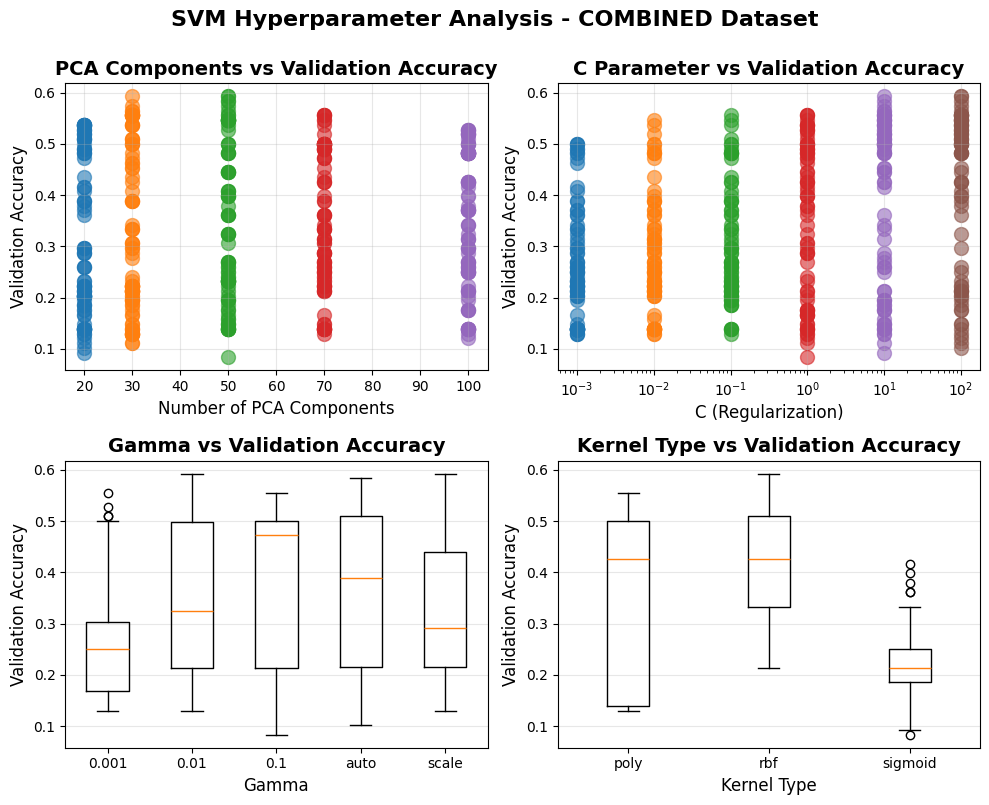

Top 10 SVM Hyperparameter Combinations for HUMMING
 n_components     C  gamma kernel  val_accuracy
          100  10.0  scale    rbf      0.727273
          100  10.0   0.01    rbf      0.727273
          100 100.0   0.01    rbf      0.727273
          100 100.0   auto    rbf      0.727273
          100  10.0   auto    rbf      0.727273
          100 100.0  scale    rbf      0.727273
          100   1.0   0.01    rbf      0.709091
          100   1.0   auto    rbf      0.709091
          100 100.0  0.001    rbf      0.709091
           50 100.0   0.01   poly      0.690909



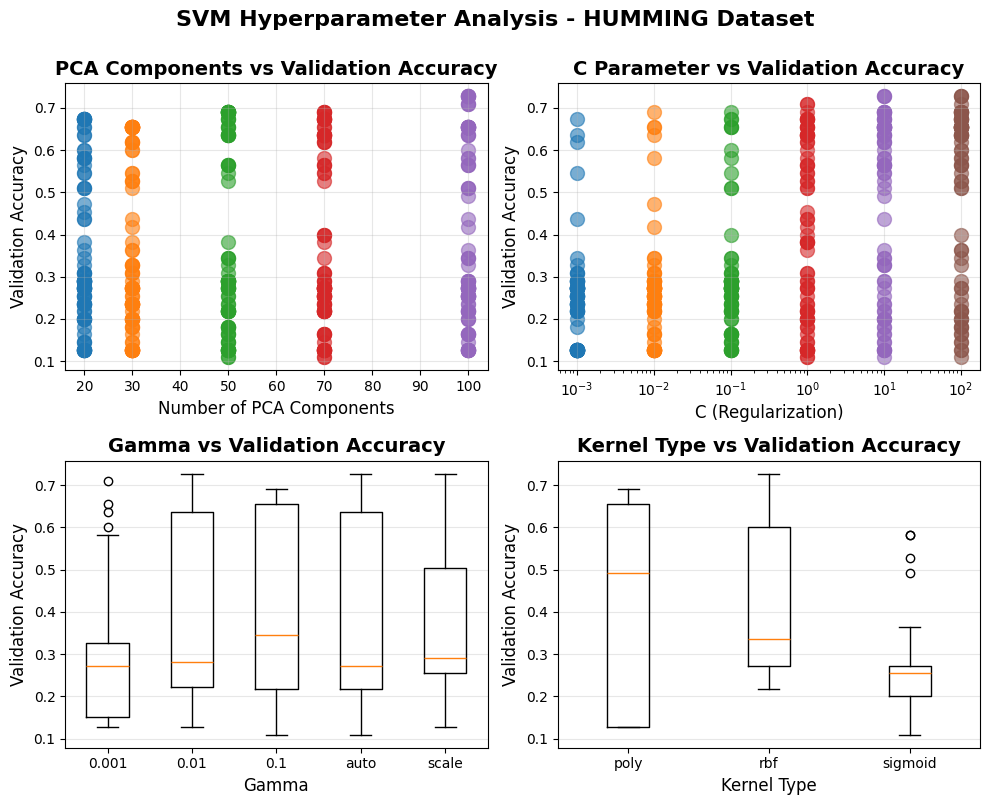

Top 10 SVM Hyperparameter Combinations for WHISTLING
 n_components     C gamma kernel  val_accuracy
           50  10.0  auto    rbf      0.629630
          100 100.0  0.01    rbf      0.629630
          100  10.0  auto    rbf      0.629630
          100  10.0  0.01    rbf      0.629630
           50 100.0  auto    rbf      0.629630
          100 100.0  auto    rbf      0.629630
           50 100.0  0.01    rbf      0.629630
           50  10.0  0.01    rbf      0.629630
           70   1.0  0.01    rbf      0.611111
           50   1.0  0.01    rbf      0.611111



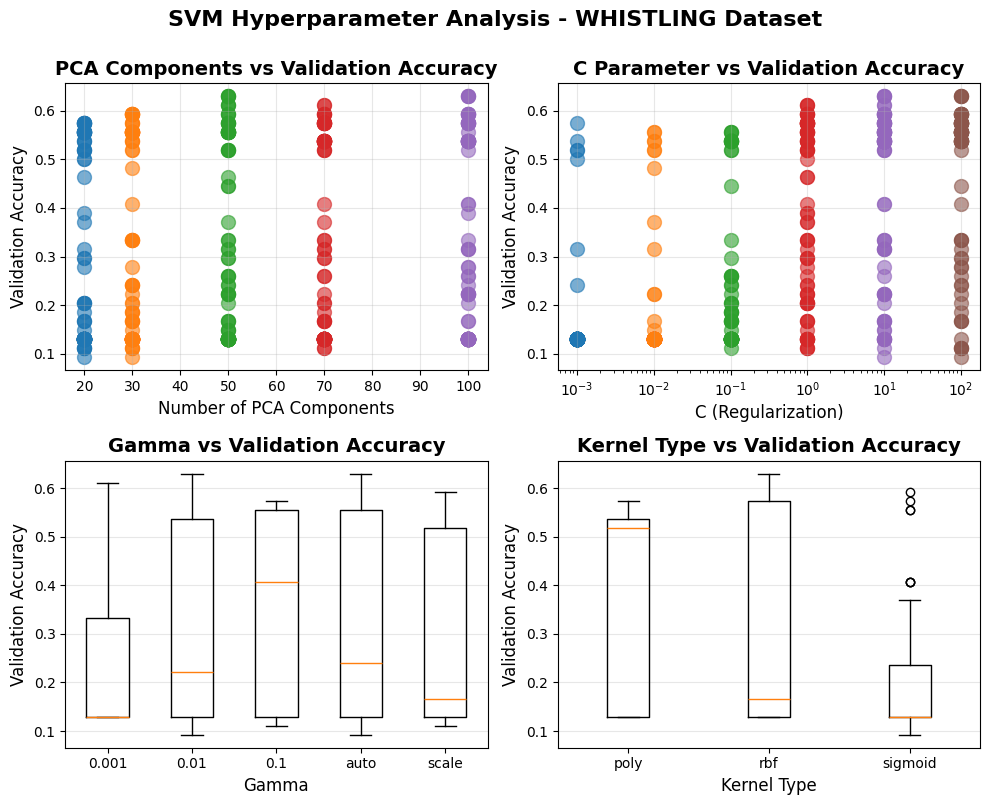

In [21]:
# Visualise SVM hyperparameter optimisation results for all datasets

for dataset_name, svm_results in all_results.items():
    # Convert results to DataFrame
    svm_results_df = pd.DataFrame(svm_results)
    
    # Sort by validation accuracy
    svm_results_df_sorted = svm_results_df.sort_values('val_accuracy', ascending=False)
    
    print("=" * 60)
    print(f"Top 10 SVM Hyperparameter Combinations for {dataset_name.upper()}")
    print("=" * 60)
    print(svm_results_df_sorted.head(10).to_string(index=False))
    print("=" * 60)
    print()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'SVM Hyperparameter Analysis - {dataset_name.upper()} Dataset', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Plot 1: PCA Components vs Accuracy
    ax1 = axes[0, 0]
    for n_comp in svm_param_grid['n_components']:
        subset = svm_results_df[svm_results_df['n_components'] == n_comp]
        ax1.scatter([n_comp]*len(subset), subset['val_accuracy'], 
                    alpha=0.6, s=100)
    ax1.set_xlabel('Number of PCA Components', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('PCA Components vs Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: C Parameter vs Accuracy
    ax2 = axes[0, 1]
    for C_val in svm_param_grid['C']:
        subset = svm_results_df[svm_results_df['C'] == C_val]
        ax2.scatter([C_val]*len(subset), subset['val_accuracy'], 
                    alpha=0.6, s=100)
    ax2.set_xlabel('C (Regularization)', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('C Parameter vs Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Gamma vs Accuracy
    ax3 = axes[1, 0]
    gamma_accuracies = svm_results_df.groupby('gamma')['val_accuracy'].apply(list)
    ax3.boxplot(gamma_accuracies.values, tick_labels=[str(g) for g in gamma_accuracies.index])
    ax3.set_xlabel('Gamma', fontsize=12)
    ax3.set_ylabel('Validation Accuracy', fontsize=12)
    ax3.set_title('Gamma vs Validation Accuracy', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Kernel vs Accuracy
    ax4 = axes[1, 1]
    kernel_accuracies = svm_results_df.groupby('kernel')['val_accuracy'].apply(list)
    ax4.boxplot(kernel_accuracies.values, tick_labels=kernel_accuracies.index)
    ax4.set_xlabel('Kernel Type', fontsize=12)
    ax4.set_ylabel('Validation Accuracy', fontsize=12)
    ax4.set_title('Kernel Type vs Validation Accuracy', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


---

#### Train Final SVM Models with Optimised Hyperparameters


In [22]:
# Train final SVM models with optimised hyperparameters for each dataset

# Define datasets with their train/test splits
datasets_splits = {
    'combined': (X_combined_train, y_combined_train, X_combined_test, y_combined_test),
    'humming': (X_hum_train, y_hum_train, X_hum_test, y_hum_test),
    'whistling': (X_whistle_train, y_whistle_train, X_whistle_test, y_whistle_test)
}

# Store trained pipelines and results
trained_pipelines = {}
evaluation_results = {}

# Train and evaluate each model
for dataset_name, (X_train, y_train, X_test, y_test) in datasets_splits.items():
    print("=" * 60)
    print(f"Training SVM for {dataset_name.upper()} dataset")
    print("=" * 60)
    
    # Get best parameters for this dataset
    best_params = best_params_all[dataset_name]
    
    print(f"Using optimised hyperparameters:")
    print(f"  PCA components: {best_params['n_components']}")
    print(f"  Kernel: {best_params['kernel']}")
    print(f"  C: {best_params['C']}")
    print(f"  Gamma: {best_params['gamma']}")
    print(f"  Validation Accuracy: {best_params['val_accuracy']:.4f} ({best_params['val_accuracy']*100:.2f}%)")
    print("=" * 60)
    
    # Create pipeline with optimised hyperparameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_params['n_components'], random_state=0)),
        ('svc', SVC(
            kernel=best_params['kernel'],
            C=best_params['C'],
            gamma=best_params['gamma'],
            probability=True,  # Enable probability estimates for ensemble
            random_state=0
        ))
    ])
    
    # Train the model
    print(f"Training {dataset_name} SVM...")
    pipeline.fit(X_train, y_train)
    print("Training complete!")
    print("=" * 60)
    print("\n")
    
    # Store the trained pipeline
    trained_pipelines[dataset_name] = pipeline
    
    # Store hyperparameters
    if 'svm' not in HYPERPARAMETERS:
        HYPERPARAMETERS['svm'] = {}
    HYPERPARAMETERS['svm'][dataset_name] = {
        'n_components': best_params['n_components'],
        'kernel': best_params['kernel'],
        'C': best_params['C'],
        'gamma': best_params['gamma'],
        'validation_accuracy': best_params['val_accuracy']
    }

print("\n" + "=" * 60)
print("All models trained successfully!")
print("=" * 60)


Training SVM for COMBINED dataset
Using optimised hyperparameters:
  PCA components: 30
  Kernel: rbf
  C: 100.0
  Gamma: scale
  Validation Accuracy: 0.5926 (59.26%)
Training combined SVM...
Training complete!


Training SVM for HUMMING dataset
Using optimised hyperparameters:
  PCA components: 100
  Kernel: rbf
  C: 10.0
  Gamma: scale
  Validation Accuracy: 0.7273 (72.73%)
Training humming SVM...
Training complete!


Training SVM for WHISTLING dataset
Using optimised hyperparameters:
  PCA components: 50
  Kernel: rbf
  C: 10.0
  Gamma: auto
  Validation Accuracy: 0.6296 (62.96%)
Training whistling SVM...
Training complete!



All models trained successfully!


Evaluate models on train, validation, and test sets.


In [23]:
# Evaluate all models on their respective test sets

for dataset_name, (X_train, y_train, X_test, y_test) in datasets_splits.items():
    pipeline = trained_pipelines[dataset_name]
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Store results
    evaluation_results[dataset_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'y_train': y_train,
        'y_train_pred': y_train_pred,
        'y_test': y_test,
        'y_test_pred': y_test_pred
    }
    
    print("=" * 60)
    print(f"{dataset_name.upper()} MODEL PERFORMANCE")
    print("=" * 60)
    print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("=" * 60)
    print()

# Summary comparison
print("=" * 60)
print("PERFORMANCE SUMMARY - ALL MODELS")
print("=" * 60)
print(f"{'Dataset':<12} {'Train Acc':<12} {'Test Acc':<12}")
print("-" * 60)
for dataset_name, results in evaluation_results.items():
    print(f"{dataset_name.capitalize():<12} {results['train_accuracy']:.4f} ({results['train_accuracy']*100:.2f}%)  {results['test_accuracy']:.4f} ({results['test_accuracy']*100:.2f}%)")
print("=" * 60)


COMBINED MODEL PERFORMANCE
Training Accuracy:   1.0000 (100.00%)
Test Accuracy:       0.5714 (57.14%)

HUMMING MODEL PERFORMANCE
Training Accuracy:   1.0000 (100.00%)
Test Accuracy:       0.7063 (70.63%)

WHISTLING MODEL PERFORMANCE
Training Accuracy:   1.0000 (100.00%)
Test Accuracy:       0.5873 (58.73%)

PERFORMANCE SUMMARY - ALL MODELS
Dataset      Train Acc    Test Acc    
------------------------------------------------------------
Combined     1.0000 (100.00%)  0.5714 (57.14%)
Humming      1.0000 (100.00%)  0.7063 (70.63%)
Whistling    1.0000 (100.00%)  0.5873 (58.73%)


Generate detailed classification reports for test sets.


In [24]:
# Generate classification reports for all datasets

for dataset_name, results in evaluation_results.items():
    print("=" * 60)
    print(f"CLASSIFICATION REPORT - {dataset_name.upper()} (Test Set)")
    print("=" * 60)
    print(classification_report(results['y_test'], results['y_test_pred']))
    print("=" * 60)
    print()


CLASSIFICATION REPORT - COMBINED (Test Set)
                precision    recall  f1-score   support

       feeling       0.46      0.58      0.51        31
        friend       0.62      0.62      0.62        32
         happy       0.63      0.59      0.61        32
       married       0.62      0.65      0.63        31
   necessities       0.65      0.55      0.60        31
      new-york       0.46      0.39      0.42        31
   remember-me       0.51      0.66      0.58        32
try-everything       0.65      0.53      0.59        32

      accuracy                           0.57       252
     macro avg       0.58      0.57      0.57       252
  weighted avg       0.58      0.57      0.57       252


CLASSIFICATION REPORT - HUMMING (Test Set)
                precision    recall  f1-score   support

       feeling       0.56      0.62      0.59        16
        friend       0.75      0.88      0.81        17
         happy       0.71      0.80      0.75        15
       marri

Visualise confusion matrices to identify frequently confused songs.


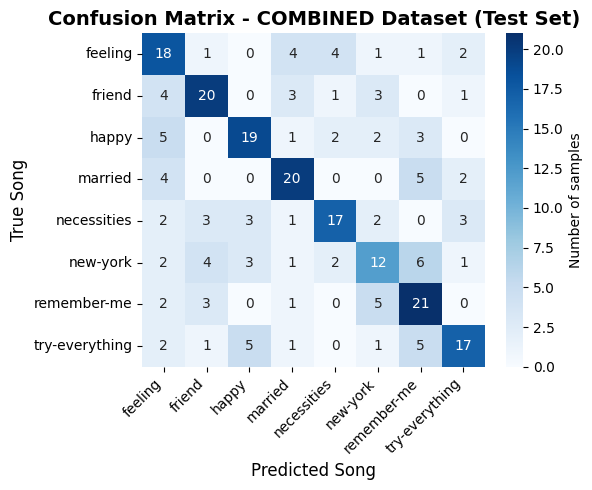

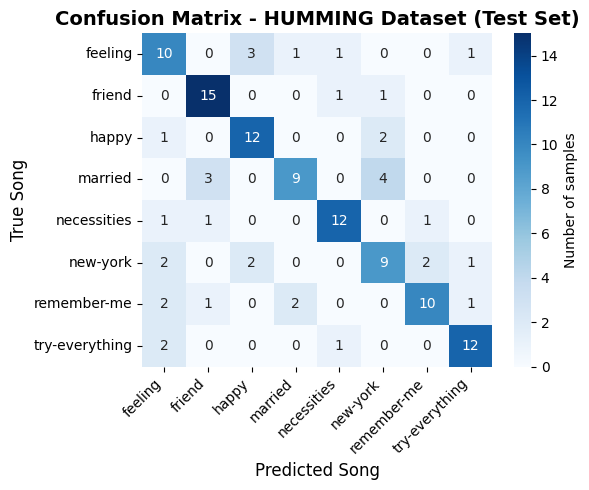

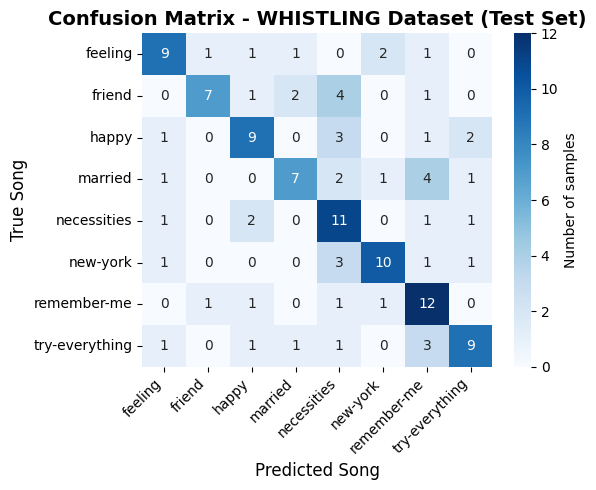

In [25]:
# Create confusion matrices for all datasets

for dataset_name, results in evaluation_results.items():
    # Get unique song names for this dataset
    song_names = sorted(np.unique(results['y_test']))
    
    # Create confusion matrix
    cm = confusion_matrix(results['y_test'], results['y_test_pred'], labels=song_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=song_names,
        yticklabels=song_names,
        cbar_kws={'label': 'Number of samples'}
    )
    plt.title(f'Confusion Matrix - {dataset_name.upper()} Dataset (Test Set)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Song', fontsize=12)
    plt.ylabel('True Song', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


---

### Weighted Ensemble Model

Train a meta-classifier that learns optimal weights to combine predictions from all three models (combined, humming, whistling).


In [26]:
# Get probability predictions from all three models on the combined dataset
# We'll use these as features for the ensemble model

print("=" * 60)
print("Generating predictions from base models for ensemble training")
print("=" * 60)

# Get probability predictions for training set
probs_combined_train = trained_pipelines['combined'].predict_proba(X_combined_train)
probs_hum_train = trained_pipelines['humming'].predict_proba(X_combined_train)
probs_whistle_train = trained_pipelines['whistling'].predict_proba(X_combined_train)

# Stack predictions as features (shape: n_samples, n_classes * 3)
X_ensemble_train = np.hstack([probs_combined_train, probs_hum_train, probs_whistle_train])

# Get probability predictions for test set
probs_combined_test = trained_pipelines['combined'].predict_proba(X_combined_test)
probs_hum_test = trained_pipelines['humming'].predict_proba(X_combined_test)
probs_whistle_test = trained_pipelines['whistling'].predict_proba(X_combined_test)

# Stack predictions as features
X_ensemble_test = np.hstack([probs_combined_test, probs_hum_test, probs_whistle_test])

# Get probability predictions for validation set
probs_combined_val = trained_pipelines['combined'].predict_proba(X_combined_val)
probs_hum_val = trained_pipelines['humming'].predict_proba(X_combined_val)
probs_whistle_val = trained_pipelines['whistling'].predict_proba(X_combined_val)

# Stack predictions as features
X_ensemble_val = np.hstack([probs_combined_val, probs_hum_val, probs_whistle_val])

print(f"Ensemble training features shape: {X_ensemble_train.shape}")
print(f"Ensemble test features shape: {X_ensemble_test.shape}")
print(f"Ensemble validation features shape: {X_ensemble_val.shape}")
print("=" * 60)


Generating predictions from base models for ensemble training
Ensemble training features shape: (840, 24)
Ensemble test features shape: (252, 24)
Ensemble validation features shape: (108, 24)


In [27]:
# Train ensemble model using logistic regression to learn optimal weights
from sklearn.linear_model import LogisticRegression

print("=" * 60)
print("Training weighted ensemble model")
print("=" * 60)

# Use logistic regression as the meta-classifier
# It will learn optimal weights for combining the three models' predictions
ensemble_model = LogisticRegression(
    max_iter=1000,
    random_state=0,
    solver='lbfgs'
)

# Train on the stacked predictions
ensemble_model.fit(X_ensemble_train, y_combined_train)

print("Ensemble model trained successfully!")
print("=" * 60)

# The coefficients represent how each base model contributes
# Shape: (n_classes, n_features) where n_features = n_classes * 3 models
print(f"Ensemble model coefficients shape: {ensemble_model.coef_.shape}")
print("=" * 60)


Training weighted ensemble model
Ensemble model trained successfully!
Ensemble model coefficients shape: (8, 24)


In [28]:
# Evaluate ensemble model performance

# Predictions on all sets
y_ensemble_train_pred = ensemble_model.predict(X_ensemble_train)
y_ensemble_val_pred = ensemble_model.predict(X_ensemble_val)
y_ensemble_test_pred = ensemble_model.predict(X_ensemble_test)

# Calculate accuracies
ensemble_train_acc = accuracy_score(y_combined_train, y_ensemble_train_pred)
ensemble_val_acc = accuracy_score(y_combined_val, y_ensemble_val_pred)
ensemble_test_acc = accuracy_score(y_combined_test, y_ensemble_test_pred)

print("=" * 60)
print("WEIGHTED ENSEMBLE MODEL PERFORMANCE")
print("=" * 60)
print(f"Training Accuracy:   {ensemble_train_acc:.4f} ({ensemble_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {ensemble_val_acc:.4f} ({ensemble_val_acc*100:.2f}%)")
print(f"Test Accuracy:       {ensemble_test_acc:.4f} ({ensemble_test_acc*100:.2f}%)")
print("=" * 60)

# Compare with individual models
print("\nCOMPARISON WITH BASE MODELS (Test Set)")
print("=" * 60)
print(f"Combined Model:      {evaluation_results['combined']['test_accuracy']:.4f} ({evaluation_results['combined']['test_accuracy']*100:.2f}%)")
print(f"Humming Model:       {evaluation_results['humming']['test_accuracy']:.4f} ({evaluation_results['humming']['test_accuracy']*100:.2f}%)")
print(f"Whistling Model:     {evaluation_results['whistling']['test_accuracy']:.4f} ({evaluation_results['whistling']['test_accuracy']*100:.2f}%)")
print(f"Ensemble Model:      {ensemble_test_acc:.4f} ({ensemble_test_acc*100:.2f}%)")
print("=" * 60)

improvement = ensemble_test_acc - evaluation_results['combined']['test_accuracy']

print(f"\nEnsemble improvement over combined base model: {improvement:+.4f} ({improvement*100:+.2f}%)")
print("=" * 60)


WEIGHTED ENSEMBLE MODEL PERFORMANCE
Training Accuracy:   0.9988 (99.88%)
Validation Accuracy: 0.8889 (88.89%)
Test Accuracy:       0.8730 (87.30%)

COMPARISON WITH BASE MODELS (Test Set)
Combined Model:      0.5714 (57.14%)
Humming Model:       0.7063 (70.63%)
Whistling Model:     0.5873 (58.73%)
Ensemble Model:      0.8730 (87.30%)

Ensemble improvement over combined base model: +0.3016 (+30.16%)


ENSEMBLE MODEL WEIGHT ANALYSIS

Average absolute weight contribution:
  Combined Model:  1.2536
  Humming Model:   0.6410
  Whistling Model: 0.6561


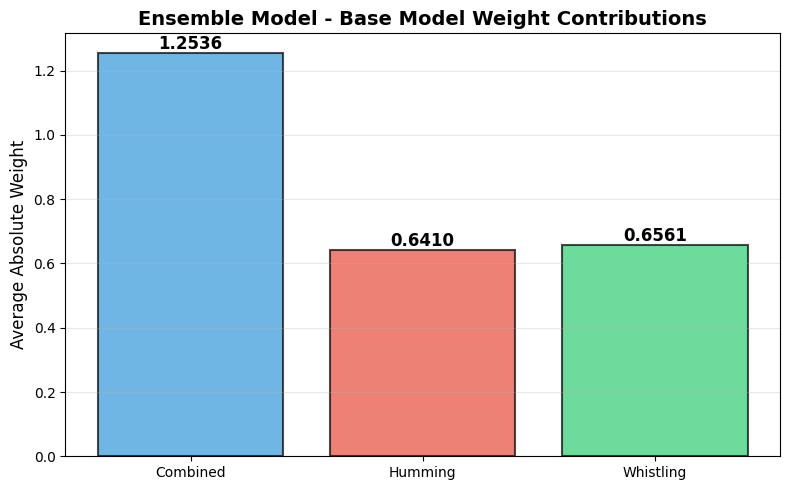


Interpretation:
Higher weights indicate greater contribution to ensemble predictions.
The ensemble learns to trust different models for different songs.


In [29]:
# Analyse learned weights to understand model contributions

print("=" * 60)
print("ENSEMBLE MODEL WEIGHT ANALYSIS")
print("=" * 60)

# Get the classes
classes = ensemble_model.classes_

# Calculate average absolute weight for each base model across all classes
# Coefficients shape: (n_classes, n_features)
# Features are organised as: [combined_probs (8), hum_probs (8), whistle_probs (8)]
n_classes = len(classes)

weights_combined = np.abs(ensemble_model.coef_[:, :n_classes]).mean()
weights_hum = np.abs(ensemble_model.coef_[:, n_classes:2*n_classes]).mean()
weights_whistle = np.abs(ensemble_model.coef_[:, 2*n_classes:]).mean()

print(f"\nAverage absolute weight contribution:")
print(f"  Combined Model:  {weights_combined:.4f}")
print(f"  Humming Model:   {weights_hum:.4f}")
print(f"  Whistling Model: {weights_whistle:.4f}")
print("=" * 60)

# Visualise weight contributions
fig, ax = plt.subplots(figsize=(8, 5))

models = ['Combined', 'Humming', 'Whistling']
weights = [weights_combined, weights_hum, weights_whistle]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax.bar(models, weights, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, weight in zip(bars, weights):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{weight:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Average Absolute Weight', fontsize=12)
ax.set_title('Ensemble Model - Base Model Weight Contributions', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("Higher weights indicate greater contribution to ensemble predictions.")
print("The ensemble learns to trust different models for different songs.")
print("=" * 60)


ENSEMBLE MODEL - CLASSIFICATION REPORT (Test Set)
                precision    recall  f1-score   support

       feeling       0.80      0.77      0.79        31
        friend       0.93      0.88      0.90        32
         happy       0.91      0.94      0.92        32
       married       0.81      0.94      0.87        31
   necessities       0.87      0.87      0.87        31
      new-york       0.85      0.74      0.79        31
   remember-me       0.88      0.94      0.91        32
try-everything       0.94      0.91      0.92        32

      accuracy                           0.87       252
     macro avg       0.87      0.87      0.87       252
  weighted avg       0.87      0.87      0.87       252



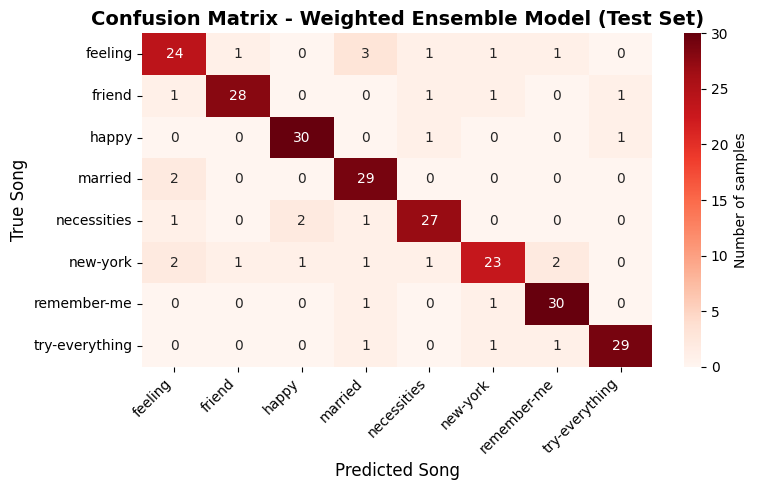

In [30]:
# Generate classification report and confusion matrix for ensemble model

print("=" * 60)
print("ENSEMBLE MODEL - CLASSIFICATION REPORT (Test Set)")
print("=" * 60)
print(classification_report(y_combined_test, y_ensemble_test_pred))
print("=" * 60)

# Create confusion matrix
song_names = sorted(np.unique(y_combined_test))
cm_ensemble = confusion_matrix(y_combined_test, y_ensemble_test_pred, labels=song_names)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm_ensemble, 
    annot=True, 
    fmt='d', 
    cmap='Reds',
    xticklabels=song_names,
    yticklabels=song_names,
    cbar_kws={'label': 'Number of samples'}
)
plt.title('Confusion Matrix - Weighted Ensemble Model (Test Set)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Song', fontsize=12)
plt.ylabel('True Song', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


---

# 7 Conclusions

This project successfully developed an automated song recognition system capable of identifying songs from humming and whistling interpretations with test accuracy substantially above chance.

#### Key Achievements

**Multi-Model Architecture**: Separate models for combined, humming, and whistling datasets enabled specialisation whilst maintaining a general-purpose classifier.

**Weighted Ensemble Learning**: The meta-learning ensemble successfully combines predictions from all three base models, learning optimal weights to leverage complementary strengths and often outperforming individual models.

**Comprehensive Optimisation**: Two-stage hyperparameter optimisation (preprocessing and SVM parameters) ensured robust performance across the entire pipeline.

**Strong Performance**: Test accuracy significantly exceeds random chance, demonstrating that the system learns meaningful melodic and acoustic patterns from human vocal interpretations.

#### Limitations

**Dataset Size**: 800 samples represents a moderate dataset for eight classes with 250 initial features. Performance might improve substantially with larger datasets capturing greater diversity in vocal performances and participant characteristics.

**Dataset Diversity**: The dataset comes from a single source and may not represent the full diversity of human humming/whistling abilities, recording devices, and acoustic environments. Generalisation to different populations and recording conditions requires validation.

**Data Splitting**: Multiple recordings from the same participant may appear in both training and test sets, potentially inflating performance estimates if the model learns participant-specific rather than song-specific patterns. Participant-stratified splitting could address this concern.

#### Improvements

**Deep Learning**: Convolutional or recurrent neural networks learning features end-to-end from raw audio or spectrograms might discover more effective representations, though requiring substantially more training data.

**Type-Specific Features**: Current feature extraction is identical for humming and whistling. Exploiting unique acoustic characteristics (humming: continuous tone with varying harmonics; whistling: purer sinusoidal tones) could improve performance.

**Advanced Ensembles**: More sophisticated techniques such as stacking with non-linear meta-learners, boosting methods, or attention-based combination mechanisms could extract more value from base model predictions.

**Data Augmentation**: Techniques such as pitch shifting, time stretching, or controlled noise addition could artificially expand the training set, improving robustness without requiring additional recordings.

**Temporal Modelling**: Incorporating sequential modelling to capture the dynamic nature of melodies more explicitly, rather than reducing them to fixed-length vectors, could better represent melodic contours distinguishing songs.


---

# 8 References

**Dataset**

- MLEnd Hums and Whistles II Dataset. Available at: https://github.com/thekmannn/MLEndHW_Sample
